<a href="https://colab.research.google.com/github/TomasCajan/DataScience/blob/main/P1_HousePrices_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome to my first Data Science portfolio project !

Please use the button above to display this notebook in Colab for all visualizations to be working correctly

This jupyter notebook shows my attempt to reach TOP 25% in Kaggle competition **House Prices - Advanced Regression Techniques**.

As its name suggests, it is a regression task about prediction of House Prices based on 79 explanatory features.

---
For more info about the competition please check out the official Kaggle webpage at 

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques



In [ ]:
# Load input data from GitHub, check shape
import pandas as pd
!wget https://raw.githubusercontent.com/TomasCajan/DataScience/main/Data/P1_test.csv
!wget https://raw.githubusercontent.com/TomasCajan/DataScience/main/Data/P1_train.csv
!wget https://raw.githubusercontent.com/TomasCajan/DataScience/main/Data/P1_sample_submission.csv
test = pd.read_csv("P1_test.csv")
train = pd.read_csv("P1_train.csv")
check = pd.read_csv("P1_train.csv")
submission = pd.read_csv("P1_sample_submission.csv")
print(f"Train Shape : {train.shape}")
print(f"Test Shape : {test.shape}")
print(f"Submission Shape : {submission.shape}")

--2023-01-05 23:21:22--  https://raw.githubusercontent.com/TomasCajan/DataScience/main/Data/P1_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 451405 (441K) [text/plain]
Saving to: ‘P1_test.csv.3’

P1_test.csv.3       100%[===================>] 440.83K  --.-KB/s    in 0.04s   

2023-01-05 23:21:22 (11.7 MB/s) - ‘P1_test.csv.3’ saved [451405/451405]

--2023-01-05 23:21:22--  https://raw.githubusercontent.com/TomasCajan/DataScience/main/Data/P1_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460676 (450K) [text/pl

In [ ]:
# All the necessary imports
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import GridspecLayout
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import KFold, cross_val_score
from math import ceil
import keras
from datetime import datetime
from scipy.stats import skew 
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import LassoCV , RidgeCV
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import scipy.stats as stats
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Save IDs for later
train_ID = train['Id']
test_ID = test['Id']
train_cor = train.copy()

In [ ]:
# Drop ID from main dataframe because it is not needed for regression
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

In [ ]:
base_skew = train['SalePrice'].copy()

In [ ]:
# Deleting obvious outlier values
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)

# **Exploratory Data Analysis**

In [ ]:
# Observe distribution of target variable as a Histogram
fig = px.histogram(base_skew, x="SalePrice",nbins = 100, width=800, height=450, title="Distribution of target variable", color_discrete_sequence=['red'])
fig.update_layout(title={'x':0.5})
fig.show(renderer="colab")
display(f'Skew of target variable is {round(base_skew.skew(),3)}')

'Skew of target variable is 1.883'

In [ ]:
# Observe distribution of target variable as a Boxplot
fig = px.box(base_skew, x="SalePrice", width=800, height=450,title="Distribution of target variable",color_discrete_sequence=['red'])
fig.update_layout(title={'x':0.5})
fig.show()

In [ ]:
# Reduce the skew of target variable by Log Transformation
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train.SalePrice.reset_index(drop=True).copy()
train = train.drop(['SalePrice'], axis=1)

In [ ]:
# Observe distribution of target variable 
fig = px.histogram(y, x="SalePrice",nbins = 100, width=800, height=450,
                   title="Distribution of target variable after Log Transform")
fig.update_layout(title={'x':0.5})
fig.show(renderer="colab")
display(f'Skew of target variable is {round(y.skew(),3)}')

'Skew of target variable is 0.122'

In [ ]:
# Observe distribution of target variable as a Boxplot
fig = px.box(y, x="SalePrice", width=800, height=450,title="Distribution of target variable after Log Transform",color_discrete_sequence=['Blue'])
fig.update_layout(title={'x':0.5})
fig.show()

In [ ]:
# Compare distribution shapes before and after Log Transform
fig=make_subplots(specs=[[{"secondary_y": True}]])
fig.update_layout(xaxis2= {'anchor': 'y', 'overlaying': 'x', 'side': 'top'},yaxis_domain=[0, 0.94])
fig.add_trace(go.Histogram(x=base_skew, name="Before Log Transform", marker_color='red'),secondary_y=False)

fig.add_trace(go.Histogram(x=y, name="After Log Transform", marker_color='blue'),secondary_y=True)

fig.data[1].update(xaxis='x2')
fig.update_layout(width=800, height=450, title={'text': "Distribution Comparison",'x':0.45,},
                   xaxis_title="SalePrice ( ranges vary )", yaxis_title="Count")
fig.update_traces(opacity=0.7)
fig.show(renderer="colab")

In [ ]:
# Concatenate train and test dataframe
df_features = pd.concat([train, test]).reset_index(drop=True)
display(df_features.shape)

(2917, 79)

In [ ]:
# Display basic infromation about dataframe
display(df_features.dtypes.value_counts())
display(df_features.columns)

object     43
int64      25
float64    11
dtype: int64

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [ ]:
# Dataframe Head
df_features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [ ]:
# Dataframe Description
df_features.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2917.000000,2431.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2894.000000,2916.000000,2916.000000,...,2916.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000
mean,57.135756,69.180584,10139.439150,6.086390,5.564964,1971.287967,1984.248200,101.733587,439.015432,49.616255,...,472.409465,93.629414,47.280082,23.114158,2.604045,16.073363,2.088790,50.860816,6.213576,2007.792938
std,42.532140,22.791719,7807.036512,1.406704,1.113414,30.286991,20.892257,178.510291,444.182329,169.258662,...,214.620878,126.532643,67.118965,64.263424,25.196714,56.202054,34.561371,567.595198,2.713070,1.315328
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7476.000000,5.000000,5.000000,1953.000000,1965.000000,0.000000,0.000000,0.000000,...,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9452.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.000000,0.000000,...,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11556.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,4010.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [ ]:
# Create a function to display overall information about any given feature
def ShowInfo(dataframe,order):
  out_box1 = widgets.Output()
  out_box2 = widgets.Output()
  
  se_desc = train.describe(include='all').loc[:,train.columns[order-1]]
  df_desc = se_desc.to_frame()

  with out_box1:
    display(df_desc)

  with out_box2:
    fig = make_subplots(rows=1, cols=3, subplot_titles=(f'{dataframe.columns[order-1]} Histogram', f'{dataframe.columns[order-1]} BoxPlot', f'{dataframe.columns[order-1]} vs target variable'))
    fig.add_trace(go.Histogram(x=dataframe.iloc[:,order], marker_color='blue'),row=1, col=1)
    fig.add_trace(go.Box(x=dataframe.iloc[:,order], name=" "),row=1, col=2)
    fig.add_trace(go.Scatter(y=check['SalePrice'], x=dataframe.iloc[:,order],mode='markers'),row=1, col=3)
    fig.update_layout(autosize=False, width=1500, height=500)
    fig.update_xaxes(title_text=f'{dataframe.columns[order-1]}')
    fig.update_layout(showlegend=False)
    fig.show(renderer="colab")

  grid = GridspecLayout(8, 8)
  grid[:, 0] = out_box1
  grid[:, 1:8] = out_box2
  display(grid)

In [ ]:
ShowInfo(train,18)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [ ]:
# Display dataframe's datatypes, unique value counts, missing values
def ShowStruct(dataframe):
  pd.set_option('display.max_rows', 80)
  pd.set_option('display.max_columns', 30)

  df_info = pd.DataFrame(dataframe.dtypes, columns=['Dtype'])
  df_info['Unique'] = dataframe.nunique().values
  df_info['Null'] = dataframe.isnull().sum().values
  display(df_info)

In [ ]:
ShowStruct(df_features)

,Dtype,Unique,Null
MSSubClass,int64,16,0
MSZoning,object,5,4
LotFrontage,float64,128,486
LotArea,int64,1949,0
Street,object,2,0
Alley,object,2,2719
LotShape,object,4,0
LandContour,object,4,0
Utilities,object,2,2
LotConfig,object,5,0


In [ ]:
# Display more detailed overview of missing values
def DisplayMissingValues(dataframe):
  dfMissing = pd.DataFrame()
  dfRecount = dataframe.isnull().sum().sort_values(ascending = False)[0:25]
  for i in range(len(dfRecount)):
    dfMissing = dfMissing.append({'Feature' : dfRecount.index[i],
                                  'MissingValues' : dfRecount.iloc[i],
                                  'PercentMissing' : (dfRecount.iloc[i] / dataframe.shape[0] * 100).round(2)
                                  }, ignore_index = True)
  dfMissing = dfMissing.set_index("Feature")

  out_box1 = widgets.Output()
  out_box2 = widgets.Output()

  with out_box1:
      display(dfMissing)
      
  with out_box2:
      total = dataframe.isnull().sum().sort_values(ascending=False)
      percent = (dataframe.isnull().sum()/dataframe.isnull().count()).sort_values(ascending=False)*100
      missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])[0:25]

      f, ax = plt.subplots(1,3, figsize=(45,12))
      plt.xticks(rotation=90)

      g = sns.barplot(x=missing_data.index, y=missing_data['Percent'],ax=ax[0])
      g.set_title('Percentage missing data by feature', fontsize=20)
      g.set_xticklabels(g.get_xticklabels(), rotation=90)

      g1 = sns.heatmap(dataframe.isnull(),yticklabels=False, ax=ax[1], cbar=False)
      g1.set_title('Missing Values Location', fontsize=20)

      g2 = msno.heatmap((dataframe), ax=ax[2])
      g2.set_title('Correlation Missing Values', fontsize=20)
      plt.show()

  grid = GridspecLayout(8, 8)
  grid[:, 0] = out_box1
  grid[:, 1:8] = out_box2
  display(grid)

In [ ]:
DisplayMissingValues(df_features)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

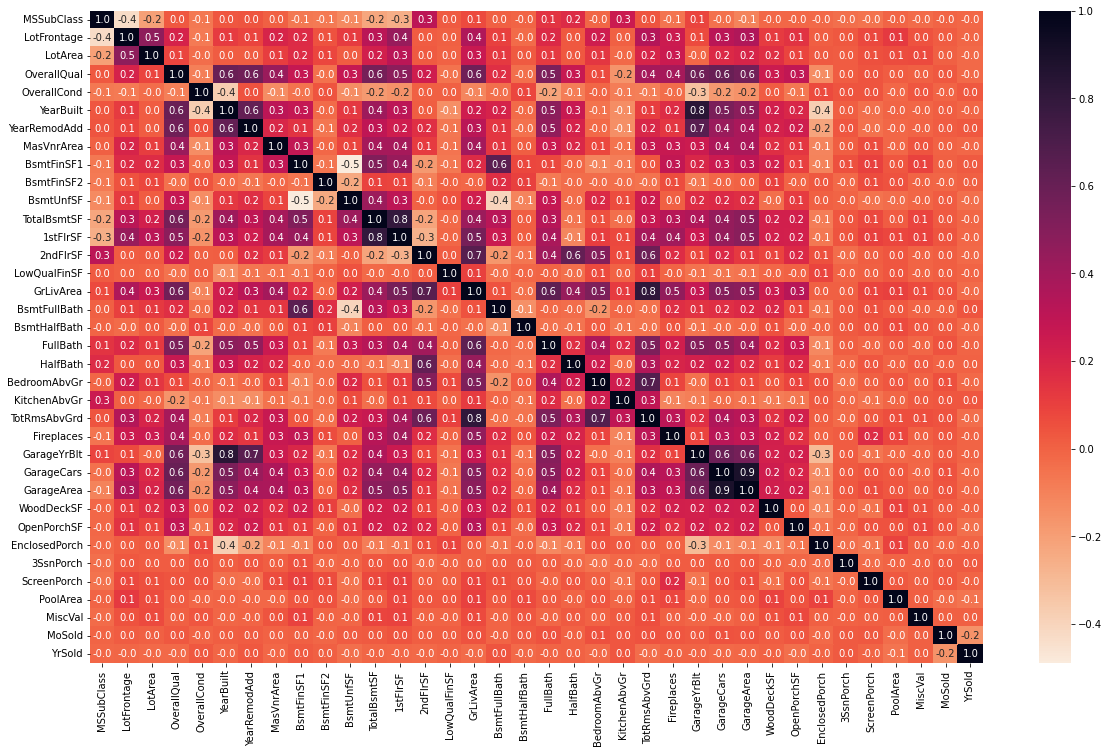

In [ ]:
# Numerical features correlation heatmap
f, ax = plt.subplots(1,1, figsize=(20,12))
sns.heatmap(df_features.corr(),annot=True, fmt='.1f',cmap="rocket_r")

In [ ]:
# Display correlation of numerical features with SalePrice target variable
df_corr = pd.DataFrame(train_cor.corr())
df_corr2 = pd.DataFrame()
for i in range (len(df_corr)):
    df_corr2 = df_corr2.append({'Feature' : df_corr.index[i],
                              'SalePrice_Corr' : df_corr["SalePrice"].iloc[i]},
                              ignore_index=True)
df_corr2 = df_corr2.sort_values(by=['SalePrice_Corr'],ascending = False)

fig = px.bar(df_corr2, x='Feature', y = "SalePrice_Corr",color='SalePrice_Corr',color_continuous_scale='Bluered_r',
             title="Correlation of Features with SalePrice")
fig.update_layout(width=1100, height=450,title={'x':0.5})
fig.show(renderer="colab")

In [ ]:
# Display relation of most correlated and least correlated features to target variable SalePrice
fig = make_subplots(rows=1, cols=2, subplot_titles=(f"Most correlated with SalePrice : {df_corr2.iloc[1].values}",
                                                    f"Least correlated with SalePrice : {df_corr2.iloc[-1].values}"))

fig.add_trace(go.Scatter(y=train_cor['SalePrice'], x=train_cor['OverallQual'],mode='markers', name="Most Correlated"),row=1, col=1)
fig.add_trace(go.Scatter(y=train_cor['SalePrice'], x=train_cor['KitchenAbvGr'],mode='markers', name="Least Correlated"),row=1, col=2)
fig.update_layout(autosize=False, width=1800, height=500)
fig.update_yaxes(title_text='SalePrice')
fig.show()

In [ ]:
# Display which features have large % missing and contain only few unique values. Some of these will be candidates to drop later
def CanDrop(dataframe):
  dfMissing = pd.DataFrame()
  dfRecount = dataframe.isnull().sum().sort_values(ascending = False)
  for i in range(len(dfRecount)):
    dfMissing = dfMissing.append({'Feature' : dfRecount.index[i],
                                  'PercentMissing' : (dfRecount.iloc[i] / dataframe.shape[0] * 100).round(2)
                                  }, ignore_index = True)
  dfValues = pd.DataFrame(columns = ['Feature', 'ValueCount'])
  for i in dataframe.columns:
    dfValues = dfValues.append({'Feature' : i,
                      'ValueCount' : df_features[i].nunique(),
                      }, ignore_index = True)
  dfJoin = dfValues.set_index('Feature').join(dfMissing.set_index('Feature'))
  dfJoin.drop(dfJoin[dfJoin.ValueCount > 3].index, inplace=True)

  sorted_df = dfJoin.sort_values(by=['PercentMissing'], ascending=False)
  display(sorted_df)

In [ ]:
CanDrop(df_features)

,ValueCount,PercentMissing
Feature,,
PoolQC,3,99.69
Alley,2,93.21
GarageFinish,3,5.45
Utilities,2,0.07
BsmtHalfBath,3,0.07
Street,2,0.00
LandSlope,3,0.00
CentralAir,2,0.00
HalfBath,3,0.00


In [ ]:
# Display histograms of PoolQC, Alley and the rest of features with only 2 unique variables
fig = make_subplots(rows=1, cols=5, subplot_titles=("PoolQC","Alley","Utilities","Street","CentralAir"))

fig.add_trace(go.Histogram(x=df_features["PoolQC"], name="PoolQC", marker_color='blue'),row=1, col=1)
fig.add_trace(go.Histogram(x=df_features["Alley"], name="Alley", marker_color='purple'),row=1, col=2)
fig.add_trace(go.Histogram(x=df_features["Utilities"], name="Utilities", marker_color='red'),row=1, col=3)
fig.add_trace(go.Histogram(x=df_features["Street"], name="Street", marker_color='violet'),row=1, col=4)
fig.add_trace(go.Histogram(x=df_features["CentralAir"], name="CentralAir", marker_color='green'),row=1, col=5)

fig.update_layout(autosize=False, width=1100, height=450)
fig.show()

### **Pre-processing and Feature Engineering**

In [ ]:
# Handling Missing Values - filling values based on clues from dataset description
df_features['Functional'] = df_features['Functional'].fillna('Typ')                                             # "Typ" is default value
df_features['Electrical'] = df_features['Electrical'].fillna("SBrkr")                                           # "SBrkr" is standard value
df_features['KitchenQual'] = df_features['KitchenQual'].fillna("TA")                                            # "TA" is standard value
df_features["PoolQC"] = df_features["PoolQC"].fillna("NA")                                                      # "NA" for missing value
df_features['Exterior1st'] = df_features['Exterior1st'].fillna(df_features['Exterior1st'].mode()[0])            # Most frequent value
df_features['Exterior2nd'] = df_features['Exterior2nd'].fillna(df_features['Exterior2nd'].mode()[0])            # Most frequent value
df_features['SaleType'] = df_features['SaleType'].fillna(df_features['SaleType'].mode()[0])                     # Most frequent value

for i in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df_features[i] = df_features[i].fillna(0)                                                                   # Impute 0
for i in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
          'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    df_features[i] = df_features[i].fillna('NA')                                                                # "NA" for missing value
                                                             
df_features['MSZoning'] = df_features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
df_features['LotFrontage'] = df_features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [ ]:
# Check how many missing values remain
nulls = df_features.isnull().sum().sort_values(ascending = False)[0:15]
df_nulls = pd.DataFrame({'Feature':nulls.index, 'Missing':nulls.values})
df_nulls


,Feature,Missing
0,MiscFeature,2812
1,Alley,2719
2,Fence,2346
3,FireplaceQu,1420
4,MasVnrType,24
5,MasVnrArea,23
6,BsmtFullBath,2
7,BsmtHalfBath,2
8,Utilities,2
9,BsmtFinSF1,1


In [ ]:
# impute 0 in rest of the numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in df_features.columns:
    if df_features[i].dtype in numeric_dtypes:
        numerics.append(i)
df_features.update(df_features[numerics].fillna(0))

In [ ]:
# List object columns from dataframe
objects = []
for i in df_features.columns:
    if df_features[i].dtype == object:
        objects.append(i)

In [ ]:
# impute 'NA' in rest of the object features
df_features.update(df_features[objects].fillna('NA'))

In [ ]:
# Confirm there are no more missing values in our dataframe
nulls = df_features.isnull().sum().sort_values(ascending = False)[0:10]
df_nulls = pd.DataFrame({'Feature':nulls.index, 'Missing':nulls.values})
df_nulls

,Feature,Missing
0,MSSubClass,0
1,BedroomAbvGr,0
2,GarageType,0
3,FireplaceQu,0
4,Fireplaces,0
5,Functional,0
6,TotRmsAbvGrd,0
7,KitchenQual,0
8,KitchenAbvGr,0
9,HalfBath,0


In [ ]:
# Display skew of numerical features in dataframe
skew_features = df_features[numerics].apply(lambda x: skew(x)).sort_values(ascending=False)
df_skews = pd.DataFrame({'Feature':skew_features.index, 'Skew':skew_features.values})
df_skews

,Feature,Skew
0,MiscVal,21.939672
1,PoolArea,17.688664
2,LotArea,13.109495
3,LowQualFinSF,12.084539
4,3SsnPorch,11.372080
5,KitchenAbvGr,4.300550
6,BsmtFinSF2,4.144503
7,EnclosedPorch,4.002344
8,ScreenPorch,3.945101
9,BsmtHalfBath,3.929996


In [ ]:
# Reduce skew by boxcox1p equation and display result
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index
high_skew_ref = high_skew.copy()

for i in skew_index:
  df_features[i] = boxcox1p(df_features[i], boxcox_normmax(df_features[i] + 1))
skew_features2 = df_features[numerics].apply(lambda x: skew(x)).sort_values(ascending=False)

skew_comp = pd.DataFrame()
for i in range(len(high_skew_ref)):
  skew_comp = skew_comp.append({'Feature' : high_skew_ref.index[i],
                                  'OriginalSkew' : high_skew_ref.iloc[i]}, ignore_index = True)
skew_comp2 = pd.DataFrame()
for i in range(len(skew_features2)):
  skew_comp2 = skew_comp2.append({'Feature' : skew_features2.index[i],
                                    'ReducedSkew' : skew_features2.iloc[i]}, ignore_index = True)
    
skew_df = skew_comp.merge(skew_comp2, how='inner', on='Feature')
skew_df

,Feature,OriginalSkew,ReducedSkew
0,MiscVal,21.939672,5.237983
1,PoolArea,17.688664,15.595057
2,LotArea,13.109495,-0.138117
3,LowQualFinSF,12.084539,8.492615
4,3SsnPorch,11.372080,8.862045
5,KitchenAbvGr,4.300550,3.778336
6,BsmtFinSF2,4.144503,2.578329
7,EnclosedPorch,4.002344,2.149133
8,ScreenPorch,3.945101,3.152631
9,BsmtHalfBath,3.929996,3.779434


In [ ]:
# Display result of skew reduction in barplot
fig = px.bar(skew_df, x='Feature', y = ["OriginalSkew","ReducedSkew"],barmode = 'overlay',
             title="Skew reduction result",color_discrete_sequence=["red", "blue"])
fig.update_layout(width=1100, height=450,title={'x':0.5})
fig.show(renderer="colab")

In [ ]:
# Drop Features. PoolQC and Alley dropped because of major part of data is missing. Street and Utilities dropped because of low variance.
features = df_features.drop(['Utilities', 'Street', 'PoolQC',"Alley"], axis=1)

In [ ]:
# Create new features by combination of existing ones
features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] + features['1stFlrSF'] + features['2ndFlrSF'])
features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) + features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))
features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] + features['EnclosedPorch'] + features['ScreenPorch'] + features['WoodDeckSF'])

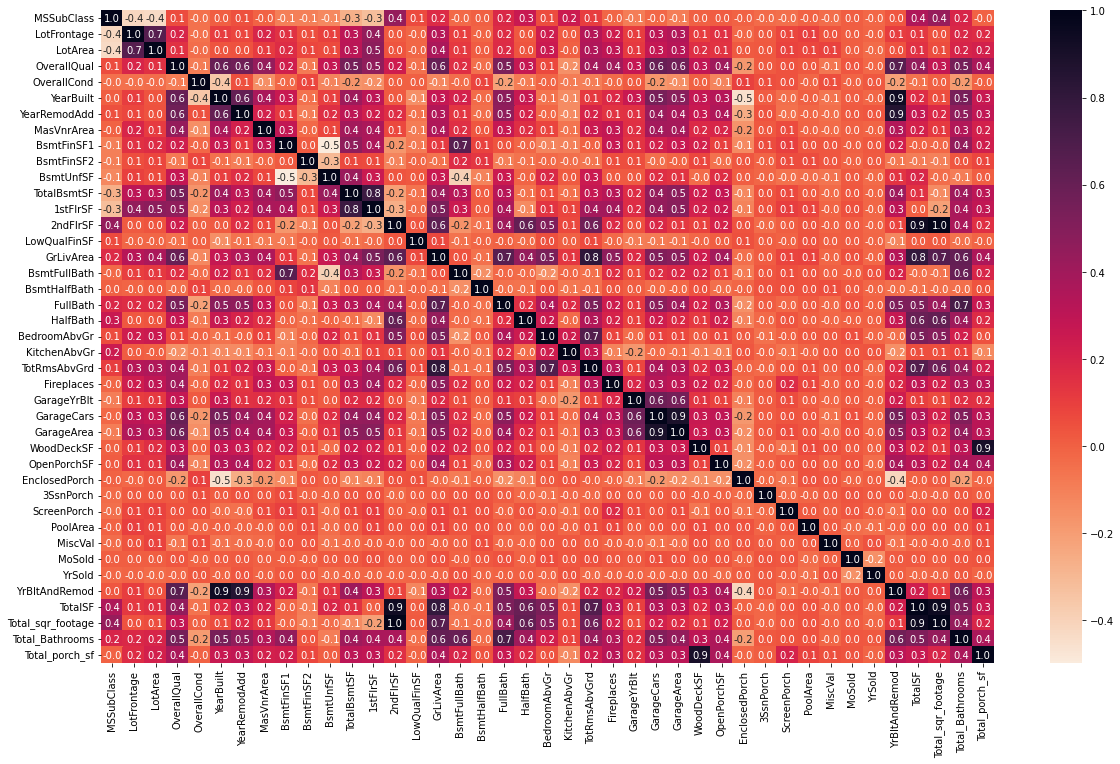

In [ ]:
# Features correlation heatmap after creating combination features
f, ax = plt.subplots(1,1, figsize=(20,12))
sns.heatmap(features.corr(),annot=True, fmt='.1f',cmap="rocket_r")

In [ ]:
# Drop most correlated features
features = features.drop(['YearBuilt','YearRemodAdd','Total_sqr_footage'], axis=1)

In [ ]:
# Create new features by simplification of features
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
features = features.drop(['PoolArea', '2ndFlrSF', 'GarageArea','TotalBsmtSF','Fireplaces'], axis=1)

In [ ]:
# Encode categorical features using Dummies
print(features.shape)
dummy_features = pd.get_dummies(features).reset_index(drop=True)
print(dummy_features.shape)

(2917, 77)
(2917, 293)


In [ ]:
# Detect outliers in dataframe using IsolationForest algorithm
iso = IsolationForest(bootstrap=True,
                          contamination=0.0025, 
                          max_features=10, 
                          max_samples=100, 
                          n_estimators=1500, 
                          random_state=42)
outlier_pred = iso.fit_predict(dummy_features)

OutlierList = []
for i in range(len(outlier_pred)):
  if outlier_pred[i] == -1 :
    OutlierList.append(i)

display(f"Number of outliers : {len(OutlierList)}")
display(OutlierList)

'Number of outliers : 8'

[88, 532, 635, 704, 1591, 1832, 1834, 2555]

In [ ]:
OutlierList = [i for i in OutlierList if i < len(y)]
OutlierList

[88, 532, 635, 704]

In [ ]:
X = dummy_features.iloc[:len(y), :]
print('X', X.shape, 'y', y.shape)
X_sub = dummy_features.iloc[len(X):, :]
print('X_sub', X_sub.shape)

X (1458, 293) y (1458,)
X_sub (1459, 293)


In [ ]:
X = X.drop(X.index[OutlierList])
y = y.drop(y.index[OutlierList])

In [ ]:
# Drop feature MSZoning_C (all) that would significantly harm Lasso model prediction later
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
overfit.append('MSZoning_C (all)')

X = X.drop(overfit, axis=1).copy()
X_sub = X_sub.drop(overfit, axis=1).copy()

In [ ]:
# Final shape before start of modeling
print('X', X.shape, 'y', y.shape)

X (1454, 292) y (1454,)


## **3 Model section**

In [ ]:
# Set up cross-validation for our model evaluation
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
# Set up model scoring function
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y,
                                    scoring="neg_mean_squared_error",
                                    cv=kfolds))
    return (rmse)

In [ ]:
# Start with default XGBoost model for baseline score
xgboost = XGBRegressor()

In [ ]:
score = cv_rmse(xgboost)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

[23:22:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:22:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:22:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:22:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:22:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:22:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:22:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:22:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
# XGBoost model setup
xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

score = cv_rmse(xgboost)
df_score = pd.DataFrame()
df_score = df_score.append({"Model": "XGBoost", "Score" : score.mean() }, ignore_index = True)
df_score.index += 1 
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now())


Xgboost score: 0.1143 (0.0179)
 2023-01-05 23:27:26.078067


In [ ]:
# Feature importance for XGBoost model
xgboost.fit(X,y)
importance = xgboost.get_booster().get_score(importance_type="weight")
xgb_feature_imp = pd.DataFrame.from_dict(data=importance, orient='index', columns=["score"]).sort_values(by = "score", ascending=False)
fig = px.bar(xgb_feature_imp, x=xgb_feature_imp.index, y = "score", color = "score",color_continuous_scale='Bluered_r', title="Feature Importance XGBoost")
fig.update_layout(width=1100, height=450,title={'x':0.5})
fig.show(renderer="colab")

In [ ]:
# Display Top 5 best predictors for XGBoost model
xgb_feature_imp[:5]

,score
LotArea,1272
BsmtUnfSF,1110
GrLivArea,1037
1stFlrSF,941
OverallQual,931


In [ ]:
# Lightgbm model setup
lightgbm = LGBMRegressor(objective='regression',
                                       num_leaves=7,
                                       max_depth=5, 
                                       learning_rate=0.009, 
                                       num_iterations = 2200,
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=2, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       lambda_l1=0.0005,
                                       verbose=-1)
score = cv_rmse(lightgbm)
df_score = df_score.append({"Model": "LightGBM", "Score" : score.mean() }, ignore_index = True)
print("Lightgbm score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now())

Lightgbm score: 0.1119 (0.0171)
 2023-01-05 23:28:12.254268


In [ ]:
# Feature importance for LightGBM model
lightgbm.fit(X,y)
lgbm_feature_imp = pd.DataFrame(sorted(zip(lightgbm.feature_importances_,X.columns)), columns=['Score','Feature']).sort_values(by = "Score", ascending=False)
lgbm_feature_imp = lgbm_feature_imp.reset_index(drop=True)
lgbm_feature_imp.index += 1 
fig = px.bar(lgbm_feature_imp, x=lgbm_feature_imp.Feature, y = "Score", color = "Score",color_continuous_scale='Bluered_r', title="Feature Importance LightGBM")
fig.update_layout(width=1100, height=450,title={'x':0.5})
fig.show(renderer="colab")

In [ ]:
# Display Top 5 best predictors for LightGBM model
lgbm_feature_imp[:5]

,Score,Feature
1,648,1stFlrSF
2,640,LotArea
3,609,GrLivArea
4,559,TotalSF
5,508,GarageYrBlt


In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Catboost model setup
from catboost import CatBoostRegressor
catboost=CatBoostRegressor(iterations=1500, learning_rate=0.03, depth = 6,  loss_function='RMSE', logging_level='Silent')
score = cv_rmse(catboost)
df_score = df_score.append({"Model": "CatBoost", "Score" : score.mean() }, ignore_index = True)
print("Catboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now())

Catboost score: 0.1141 (0.0160)
 2023-01-05 23:30:29.723317


In [ ]:
# Feature importance for Catboost model
catboost.fit(X,y)
cat_feature_imp = pd.DataFrame(sorted(zip(catboost.feature_importances_,X.columns)), columns=['Score','Feature']).sort_values(by = "Score", ascending=False)
cat_feature_imp = cat_feature_imp.reset_index(drop=True)
cat_feature_imp.index += 1 
fig = px.bar(lgbm_feature_imp, x=cat_feature_imp.Feature, y = "Score", color = "Score",color_continuous_scale='Bluered_r', title="Feature Importance Catboost")
fig.update_layout(width=1100, height=450,title={'x':0.5})
fig.show(renderer="colab")

In [ ]:
# Display Top 5 best predictors for Catboost model
cat_feature_imp[:5]

,Score,Feature
1,20.119493,OverallQual
2,10.764505,GrLivArea
3,7.643498,1stFlrSF
4,4.859349,Total_Bathrooms
5,3.823551,YrBltAndRemod


In [ ]:
# Lasso model setup
alphas_lasso = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas=alphas_lasso,
                              random_state=42, cv=kfolds))
score = cv_rmse(lasso)
df_score = df_score.append({"Model": "Lasso", "Score" : score.mean() }, ignore_index = True)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now())

Lasso score: 0.1092 (0.0155)
 2023-01-05 23:31:08.759228


In [ ]:
# Display Top 5 best predictors for Lasso model
import eli5
lasso.fit(X,y)
lasso_feature_imp = eli5.formatters.explain_weights_df(lasso,feature_names = X.columns.tolist())
lasso_feature_imp = lasso_feature_imp.drop(['target'], axis=1)
lasso_feature_imp = lasso_feature_imp.iloc[1:,:]
fig = px.bar(lasso_feature_imp, x= "feature", y = "weight", color = "weight",color_continuous_scale='Bluered_r', title="Feature Importance Lasso")
fig.update_layout(width=1100, height=450,title={'x':0.5})
fig.show(renderer="colab")

In [ ]:
# Display Top 5 best predictors for Lasso model
lasso_feature_imp[:5]

,feature,weight
1,MSZoning_FV,0.295830
2,MSZoning_RH,0.273165
3,MSZoning_RL,0.269186
4,MSZoning_RM,0.231852
5,TotalSF,0.115353


In [ ]:
# Ridge model setup
alphas_ridge = [14.9, 14.95, 15, 15.05, 15.1]
ridge = make_pipeline(RobustScaler(),
                      RidgeCV(alphas=alphas_ridge, cv=kfolds))
score = cv_rmse(ridge)
df_score = df_score.append({"Model": "Ridge", "Score" : score.mean() }, ignore_index = True)
print("Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now())

Ridge score: 0.1100 (0.0152)
 2023-01-05 23:31:24.844694


In [ ]:
# Display Top 5 best predictors for Ridge model
ridge.fit(X,y)
ridge_feature_imp = eli5.formatters.explain_weights_df(ridge,feature_names = X.columns.tolist())
ridge_feature_imp = ridge_feature_imp.drop(['target'], axis=1)
ridge_feature_imp = ridge_feature_imp.iloc[1:,:]
fig = px.bar(ridge_feature_imp, x= "feature", y = "weight", color = "weight",color_continuous_scale='Bluered_r', title="Feature Importance Ridge")
fig.update_layout(width=1100, height=450,title={'x':0.5})
fig.show(renderer="colab")

In [ ]:
# Display Top 5 best predictors for Ridge model
ridge_feature_imp[:5]

,feature,weight
1,OverallQual,0.103078
2,TotalSF,0.095131
3,GrLivArea,0.088872
4,1stFlrSF,0.077686
5,YrBltAndRemod,0.077188


In [ ]:
# SVR model setup
svr = make_pipeline(RobustScaler(),
                      SVR(C= 20, epsilon= 0.008, gamma=0.0003,))
score = cv_rmse(svr)
df_score = df_score.append({"Model": "SVR", "Score" : score.mean() }, ignore_index = True)
print("SVR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now())

SVR score: 0.1095 (0.0197)
 2023-01-05 23:31:31.574881


In [ ]:
# Compare performance score ( RMSE ) of all models
fig = px.bar(df_score, x="Model", y = "Score", color = "Score",color_continuous_scale='Bluered', title="Model Performance Comparison")
fig.update_layout(width=800, height=450,title={'x':0.5},yaxis_title="RMSE")
fig.update_layout(yaxis_range=[0.1,0.115])
fig.show(renderer="colab")

In [ ]:
# Set up Stacking CV Regressor 
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, catboost, lasso, ridge,svr),
                                meta_regressor=lasso,
                                use_features_in_secondary=True)

In [ ]:
print('START Fitting')
print(datetime.now(), 'StackingCVRegressor')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))
print(datetime.now(), 'xgboost')
xgb_model_full_data = xgboost.fit(X, y)
print(datetime.now(), 'lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)
print(datetime.now(), 'catboost')
cat_model_full_data = catboost.fit(X, y)
print(datetime.now(), 'lasso')
lasso_model_full_data = lasso.fit(X, y)
print(datetime.now(), 'ridge')
ridge_model_full_data = ridge.fit(X, y)
print(datetime.now(), 'svr')
svr_model_full_data = svr.fit(X, y)

START Fitting
2023-01-05 23:31:31.689707 StackingCVRegressor
2023-01-05 23:36:08.594557 xgboost
2023-01-05 23:36:42.352140 lightgbm
2023-01-05 23:36:43.668970 catboost
2023-01-05 23:36:53.288154 lasso
2023-01-05 23:36:54.116425 ridge
2023-01-05 23:36:55.648373 svr


In [ ]:
# rmsle
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
def blend_models_predict(X):
    return ((0.1 * cat_model_full_data.predict(X)) + \
            (0.2 * xgb_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.15 * lasso_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.25 * stack_gen_model.predict(np.array(X))))
            
print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

RMSLE score on train data:
0.07396345288626478


In [ ]:
submission.iloc[:,1] = np.floor(np.expm1(blend_models_predict(X_sub)))

In [ ]:
# Delete predictions close to the edge
q1 = submission['SalePrice'].quantile(0.0045)
q2 = submission['SalePrice'].quantile(0.99)

submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)

In [ ]:
# Save new submission
submission.to_csv("new_submission.csv", index=False)
print("Saved successfully!")

Saved successfully!


## **Summary**

The submission was ranked on 6/1/2023 at the Kaggle competition page with public score of **0.12331**

I ranked 536th out of 4497 competitors, slightly behind Top 10%.

Models still have plenty of room for tuning. Getting into Top 10% is just a matter of time !



